# Train Task2Baseline model

This is PyTorch version trainer code, will basically do the same with the original baseline written with Keras.

- Train with all machine type data, then save each models.
- Tensorboard visualization will show you training trajectories, thanks to [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning).
- And some extra visualizations.

In [1]:
# public modules
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)
from argparse import Namespace

# private modules
sys.path.append('..')
import common as com

from pytorch_common import *
from model import Task2Baseline

# loading parameters -> hparams (argparse compatible)
params = EasyDict(com.yaml_load('config.yaml'))

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode='development')

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2020-03-14 15:44:16,112 - INFO - load_directory <- development


In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
# train models

for target_dir in dirs:
    target = str(target_dir).split('/')[-1]
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    files = com.file_list_generator(target_dir)

    model = Task2Baseline().to(device)
    if target == 'ToyCar': summary(device, model)
    task2 = Task2Lightning(device, model, params, files)
    trainer = pl.Trainer(max_epochs=params.fit.epochs, gpus=torch.cuda.device_count())
    trainer.fit(task2)
    
    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')

2020-03-14 15:44:48,046 - INFO - target_dir : dev_data/ToyCar
2020-03-14 15:44:48,061 - INFO - # of training samples : 4000


==== Start training [ToyCar] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          82,048
       BatchNorm1d-2                  [-1, 128]             256
       _LinearUnit-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
       _LinearUnit-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
       BatchNorm1d-8                  [-1, 128]             256
       _LinearUnit-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
      BatchNorm1d-11                  [-1, 128]             256
      _LinearUnit-12                  [-1, 128]               0
           Linear-13                    [-1, 8]       

2020-03-14 15:44:50,311 - INFO - Creating data for 400 files: size=136000, shape=(640,)


2020-03-14 15:44:55,705 - INFO - Creating data for 3600 files: size=1224000, shape=(640,)


2020-03-14 15:45:32,265 - INFO - Loading cached __cache_ToyCar_val.npy


2020-03-14 15:46:25,886 - INFO - target_dir : dev_data/ToyConveyor
2020-03-14 15:46:25,897 - INFO - # of training samples : 3000



saved ./model/model_ToyCar.pth.

==== Start training [ToyConveyor] with 1 GPU(s). ====


2020-03-14 15:46:25,939 - INFO - Creating data for 300 files: size=92700, shape=(640,)


2020-03-14 15:46:28,854 - INFO - Creating data for 2700 files: size=834300, shape=(640,)


2020-03-14 15:46:53,403 - INFO - Loading cached __cache_ToyConveyor_val.npy


2020-03-14 15:47:29,759 - INFO - target_dir : dev_data/fan
2020-03-14 15:47:29,767 - INFO - # of training samples : 3675
2020-03-14 15:47:29,796 - INFO - Loading cached __cache_fan_val.npy



saved ./model/model_ToyConveyor.pth.

==== Start training [fan] with 1 GPU(s). ====


2020-03-14 15:47:30,364 - INFO - Creating data for 3308 files: size=1022172, shape=(640,)


2020-03-14 15:48:00,798 - INFO - Loading cached __cache_fan_val.npy


2020-03-14 15:48:45,433 - INFO - target_dir : dev_data/pump
2020-03-14 15:48:45,446 - INFO - # of training samples : 3349



saved ./model/model_fan.pth.

==== Start training [pump] with 1 GPU(s). ====


2020-03-14 15:48:45,491 - INFO - Creating data for 334 files: size=103206, shape=(640,)


2020-03-14 15:48:48,688 - INFO - Creating data for 3015 files: size=931635, shape=(640,)


2020-03-14 15:49:17,264 - INFO - Loading cached __cache_pump_val.npy


2020-03-14 15:49:56,495 - INFO - target_dir : dev_data/slider
2020-03-14 15:49:56,506 - INFO - # of training samples : 2804



saved ./model/model_pump.pth.

==== Start training [slider] with 1 GPU(s). ====


2020-03-14 15:49:56,549 - INFO - Creating data for 280 files: size=86520, shape=(640,)


2020-03-14 15:49:59,276 - INFO - Creating data for 2524 files: size=779916, shape=(640,)


2020-03-14 15:50:22,207 - INFO - Loading cached __cache_slider_val.npy


2020-03-14 15:50:55,050 - INFO - target_dir : dev_data/valve
2020-03-14 15:50:55,062 - INFO - # of training samples : 3291



saved ./model/model_slider.pth.

==== Start training [valve] with 1 GPU(s). ====


2020-03-14 15:50:55,106 - INFO - Creating data for 329 files: size=101661, shape=(640,)


2020-03-14 15:50:58,281 - INFO - Creating data for 2962 files: size=915258, shape=(640,)


2020-03-14 15:51:26,140 - INFO - Loading cached __cache_valve_val.npy



saved ./model/model_valve.pth.



## Visualize 

2020-03-16 08:47:18,619 - INFO - Loading cached __cache_ToyCar_train.npy


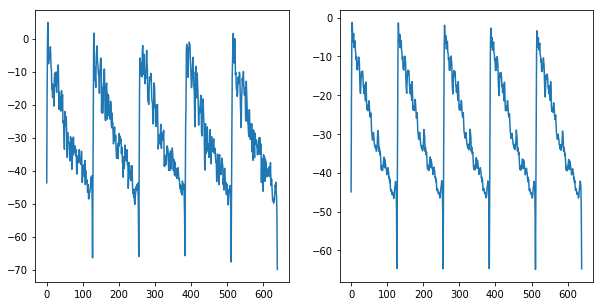

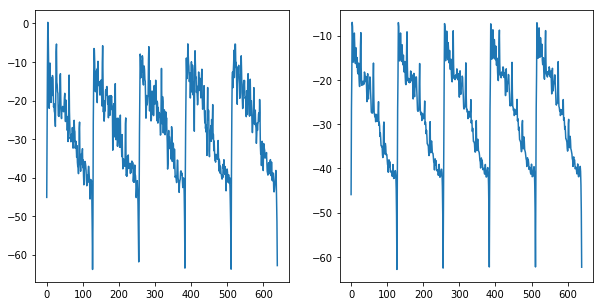

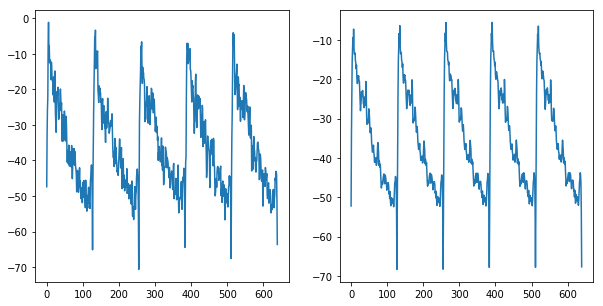

In [12]:
#load_weights(task2.model, 'model/model_ToyCar.pth')
show_some_predictions(task2.train_dataloader(), task2.model, 0, 3)

2020-03-16 08:47:23,192 - INFO - Loading cached __cache_ToyCar_val.npy


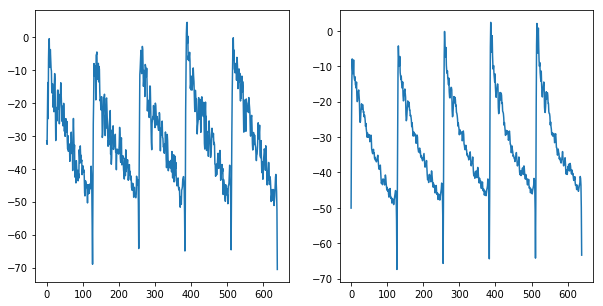

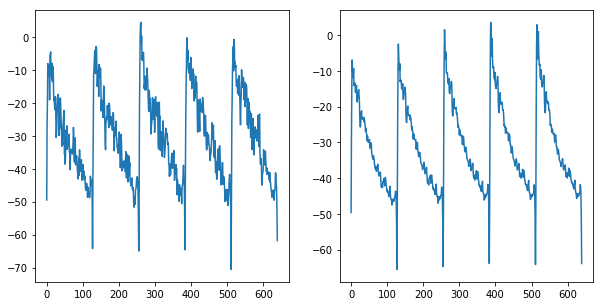

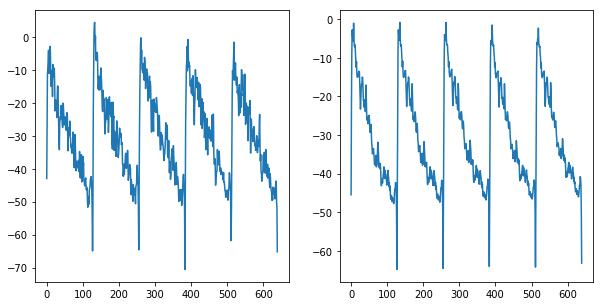

In [13]:
# Validation set samples
show_some_predictions(task2.val_dataloader(), task2.model, 0, 3)

## Data structure check

Curious about data structure? here's how `file_to_vector_array()` does.

In [21]:
# simplify problem. if we use n_mels and frames as follows,
n_mels = 2
frames = 5

# and let's set wave length is short and mel spectrogram array length is,
vector_array_size = 50

# log_mel_spectrogram will be like this.
dims = frames * n_mels
tmp = np.array(list(range(vector_array_size + frames - 1)))
log_mel_spectrogram = np.c_[tmp, tmp+0.1].T
print('simply after converting wave into log mel spectrogram, log_mel_spectrogram will have shape like this:', log_mel_spectrogram.shape)
print(log_mel_spectrogram)

simply after converting wave into log mel spectrogram, log_mel_spectrogram will have shape like this: (2, 54)
[[ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53. ]
 [ 0.1  1.1  2.1  3.1  4.1  5.1  6.1  7.1  8.1  9.1 10.1 11.1 12.1 13.1
  14.1 15.1 16.1 17.1 18.1 19.1 20.1 21.1 22.1 23.1 24.1 25.1 26.1 27.1
  28.1 29.1 30.1 31.1 32.1 33.1 34.1 35.1 36.1 37.1 38.1 39.1 40.1 41.1
  42.1 43.1 44.1 45.1 46.1 47.1 48.1 49.1 50.1 51.1 52.1 53.1]]


In [26]:
vector_array = np.zeros((vector_array_size, dims))

print(f"we'd like to arrange data structure and copy into a vector_array with shape {vector_array.shape} as follows:\n")

for t in range(frames):
    vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

print(vector_array)

we'd like to arrange data structure and copy into a vector_array with shape (50, 10) as follows:

[[ 0.   0.1  1.   1.1  2.   2.1  3.   3.1  4.   4.1]
 [ 1.   1.1  2.   2.1  3.   3.1  4.   4.1  5.   5.1]
 [ 2.   2.1  3.   3.1  4.   4.1  5.   5.1  6.   6.1]
 [ 3.   3.1  4.   4.1  5.   5.1  6.   6.1  7.   7.1]
 [ 4.   4.1  5.   5.1  6.   6.1  7.   7.1  8.   8.1]
 [ 5.   5.1  6.   6.1  7.   7.1  8.   8.1  9.   9.1]
 [ 6.   6.1  7.   7.1  8.   8.1  9.   9.1 10.  10.1]
 [ 7.   7.1  8.   8.1  9.   9.1 10.  10.1 11.  11.1]
 [ 8.   8.1  9.   9.1 10.  10.1 11.  11.1 12.  12.1]
 [ 9.   9.1 10.  10.1 11.  11.1 12.  12.1 13.  13.1]
 [10.  10.1 11.  11.1 12.  12.1 13.  13.1 14.  14.1]
 [11.  11.1 12.  12.1 13.  13.1 14.  14.1 15.  15.1]
 [12.  12.1 13.  13.1 14.  14.1 15.  15.1 16.  16.1]
 [13.  13.1 14.  14.1 15.  15.1 16.  16.1 17.  17.1]
 [14.  14.1 15.  15.1 16.  16.1 17.  17.1 18.  18.1]
 [15.  15.1 16.  16.1 17.  17.1 18.  18.1 19.  19.1]
 [16.  16.1 17.  17.1 18.  18.1 19.  19.1 20.  20.1]
 